# Q-Learning with Battery Example
This notebook demonstrates the ability of a DQN agent to learn to optimize electric battery storage.

This example involves a constant and repetitive electricity price profile, combined with a perfect forecast. The agent has both the ability to memorize this profile and lives in a near Markov environment.  

A real world application of using reinforcement learning to control a battery would have to deal with both a variable price profile and a non-Markov understanding of what the price profile would do in the future.  It could also involve additional reward signals, such as payments from fast frequency response needed to be balanced against price arbitrage.

In [1]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

import energy_py

In [2]:
#  set random seeds for repeatability
random.seed(42)
np.random.seed(42)
tf.set_random_seed(42)

In [3]:
#  define a total number of steps for the experiment to run
TOTAL_STEPS = 400000

#  to setup the agent we use a dictionary
#  a dictionary allows us to eaisly save the config to csv if we want
agent_config = {'discount': 0.97,                 #  the discount rate
                'tau': 0.001,                     #  parameter that controls the copying of weights from online to target network
                'total_steps': TOTAL_STEPS,   
                'batch_size': 32,                 #  size of the minibatches used for learning
                'layers': (50, 50),               #  structure of the neural network used to approximate Q(s,a)
                'learning_rate': 0.0001,          #  controls the stength of weight updates during learning       
                'epsilon_decay_fraction': 0.3,    #  a fraction as % of total steps where epsilon decayed from 1.0 to 0.1
                'memory_fraction': 0.4,           #  the size of the replay memory as a % of total steps
                'memory_type': 'deque',           #  the replay memory implementation we want
                'process_observation': 'standardizer',
                'process_target': 'normalizer'}    

#  keep all of the BatteryEnv variables (episode length, efficiency etc) at their defaults
#  we just need to let our env know where our state.csv and observation.csv are (data_path)
env = energy_py.make_env('Battery', dataset_name='example')

In [4]:
#  Runner is a class that helps us with experiments - tracking rewards, writing environment info to csv and managing TensorBoard
#  in this notebook we just use it to track rewards for us
runner = energy_py.Runner()

#  initialize Tensorflow machinery
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    #  add the tf session and the environment to the agent config dictionary
    #  and initialize the agent
    agent_config['sess'] = sess
    agent_config['env'] = env
    agent = energy_py.make_agent(agent_id='DQN', **agent_config)
    
    #  initial values for the step and episode number
    step, episode = 0, 0

    #  outer while loop runs through multiple episodes
    while step < TOTAL_STEPS:
        episode += 1
        done = False
        observation = env.reset()
        
        #  inner while loop runs through a single episode
        while not done:
            step += 1
            #  select an action
            action = agent.act(observation)
            
            #  take one step through the environment
            next_observation, reward, done, info = env.step(action)
            
            #  store the experience
            agent.remember(observation, action, reward,
                           next_observation, done)
            
            #  moving to the next time step
            observation = next_observation
            #  saving the reward 
            runner.append(reward)
            
            #  we don't start learning until the memory is half full
            if step > int(agent.memory.size * 0.5):
                train_info = agent.learn()
        
        if episode % 500 == 0:
            log = 'progress - {:.1f}% - episode {:.0f} - run time {:.2f} - episode reward {:.2f} - avg rewards {:.2f}'
            print(log.format(100 * step / TOTAL_STEPS,
                             episode,
                             runner.calc_time(),
                             sum(runner.ep_rewards),
                             runner.avg_rew))
            
        #  the report method should be run at the end of each episode
        runner.report({'ep': episode,
                       'step': step})

copying ['hidden_layer_1', 'Variable:0'] to ['hidden_layer_1', 'Variable:0']
copying ['hidden_layer_1', 'Variable_1:0'] to ['hidden_layer_1', 'Variable_1:0']
copying ['input_layer', 'Variable:0'] to ['input_layer', 'Variable:0']
copying ['input_layer', 'Variable_1:0'] to ['input_layer', 'Variable_1:0']
copying ['output_layer', 'Variable:0'] to ['output_layer', 'Variable:0']
copying ['output_layer', 'Variable_1:0'] to ['output_layer', 'Variable_1:0']
progress - 5.9% - episode 500 - run time 0.45 - episode reward -63.07 - avg rewards -27.56
progress - 11.8% - episode 1000 - run time 1.15 - episode reward 35.53 - avg rewards -35.01
progress - 17.6% - episode 1500 - run time 2.17 - episode reward -2.72 - avg rewards -44.10
progress - 23.5% - episode 2000 - run time 6.93 - episode reward -36.40 - avg rewards 14.01
progress - 29.4% - episode 2500 - run time 14.62 - episode reward -43.77 - avg rewards -50.63
progress - 35.2% - episode 3000 - run time 25.48 - episode reward -72.94 - avg reward

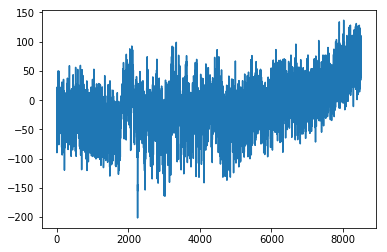

In [10]:
#  energy_py uses TensorBoard for logging - for the scope of this notebook example we will do
#  some simple plotting using matplotlib
plt.plot(runner.global_rewards, label='Total reward per episode [$]')

In [6]:
#  we can also look at what happened in our last episode
ep_hist = pd.DataFrame.from_dict(info)
ep_hist.head()

,action,done,electricity_price,gross_rate,losses,net_stored,new_charge,next_observation,next_state,observation,old_charge,reward,state,steps
0,"[1.3684210526315788, 1.789473684210526]",False,50,0.000000,0.000000,0.000000,0.000000,"[[50.0, 50.0, 50.0, 100.0, 100.0, 1.0, 1.0, 0.0]]",[[50]],"[[50.0, 50.0, 50.0, 50.0, 100.0, 0.0, 1.0, 0.0]]",0.000000,-0.000000,[[50]],1
1,"[1.0526315789473684, 1.6842105263157894]",False,50,0.000000,0.000000,0.000000,0.000000,"[[50.0, 50.0, 100.0, 100.0, 100.0, 2.0, 1.0, 0...",[[50]],"[[50.0, 50.0, 50.0, 100.0, 100.0, 1.0, 1.0, 0.0]]",0.000000,-0.000000,[[50]],2
2,"[1.789473684210526, 1.4736842105263157]",False,50,0.315789,0.002632,0.023684,0.023684,"[[50.0, 100.0, 100.0, 100.0, 100.0, 3.0, 1.0, ...",[[50]],"[[50.0, 50.0, 100.0, 100.0, 100.0, 2.0, 1.0, 0...",0.000000,-1.315789,[[50]],3
3,"[0.42105263157894735, 1.894736842105263]",False,50,-0.284211,0.000000,-0.023684,0.000000,"[[100.0, 100.0, 100.0, 100.0, 100.0, 4.0, 1.0,...",[[100]],"[[50.0, 100.0, 100.0, 100.0, 100.0, 3.0, 1.0, ...",0.023684,1.184211,[[50]],4
4,"[0.10526315789473684, 1.3684210526315788]",False,100,0.000000,0.000000,0.000000,0.000000,"[[100.0, 100.0, 100.0, 100.0, -50.0, 5.0, 1.0,...",[[100]],"[[100.0, 100.0, 100.0, 100.0, 100.0, 4.0, 1.0,...",0.000000,-0.000000,[[100]],5


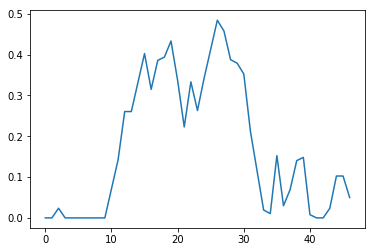

In [7]:
plt.plot(ep_hist.loc[:, 'new_charge'])

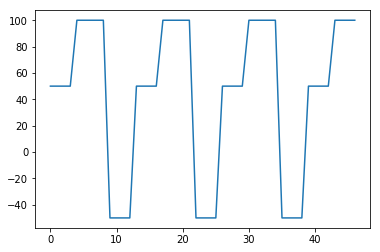

In [8]:
plt.plot(ep_hist.loc[:, 'electricity_price'])